In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from scipy import signal
from matplotlib.lines import Line2D
from sklearn import decomposition
from population import unit_activity_matrix
from spiketrain import get_shuffled
import itertools

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def make_smooth(data, k_width=25):  # k_width sampled as sound events
    kernel  = signal.gaussian(k_width, std=(k_width) / 7.2)
    return np.convolve(data, kernel, 'same') / kernel.sum()

In [22]:
def get_asterisks(pval):
    if pval > 0.05:
        return 'n.s.'
    elif pval > 0.01:
        return '*'
    elif pval > 0.001:
        return '**'
    elif pval > 0.0001:
        return '***'
    else:
        return '****'

In [25]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

# manuscript session
# '009266_hippoSIT_2023-04-18_10-10-37'

all_selected = selected_009266 + selected_009265 #+ selected_57
#selected = all_selected[:]
selected = all_selected
selected.remove('009265_hippoSIT_2023-03-05_18-31-32')
#selected.remove('57_SIT_2023-12-29_12-11-46')
#selected.remove('009265_hippoSIT_2023-03-05_18-31-32')

#selected = selected_009266
#session = selected[8]
#session

In [43]:
corrs_h_all = []
corrs_l_all = []

for i, session in enumerate(selected):
    # read dataset
    animal    = session.split('_')[0]
    s_path    = os.path.join(source, animal, session)
    meta_file = os.path.join(s_path, 'meta.h5')
    unit_file = os.path.join(s_path, 'units.h5')
    nmap_file = os.path.join(s_path, 'analysis', 'nMAP_EV_SU.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(nmap_file, 'r') as f:
        response_manifold = np.array(f['response_manifold'])
        unit_mx_su = np.array(f['unit_mx_su'])

    vals = response_manifold[:, 1]
    idxs_su_h = np.where(vals > vals.mean() + 1.5*vals.std())[0]
    idxs_su_l = np.where(vals < vals.mean() - 1.5*vals.std())[0]
    su_mx = unit_mx_su[:, 1::2].T  # take only sustained component
    
    # pairwise correlations
    unit_pair_idxs = [x for x in itertools.combinations(range(su_mx.shape[1]), 2)]
    corrs_h = np.zeros(len(unit_pair_idxs))
    corrs_l = np.zeros(len(unit_pair_idxs))
    for j, pair in enumerate(unit_pair_idxs):
        corr, pval = stats.pearsonr(su_mx[:, pair[0]][idxs_su_h], su_mx[:, pair[1]][idxs_su_h])
        if not np.isnan(corr):
            corrs_h[j] = corr
        
        corr, pval = stats.pearsonr(su_mx[:, pair[0]][idxs_su_l], su_mx[:, pair[1]][idxs_su_l])
        if not np.isnan(corr):
            corrs_l[j] = corr
        
    corrs_h_all.append(np.array(corrs_h))
    corrs_l_all.append(np.array(corrs_l))
    
    print('\rSession %s done' % session[-19:-6], end='')

Session 2023-03-10_09 done

In [44]:
corrs_h_flat = np.concatenate([x for x in corrs_h_all])
corrs_l_flat = np.concatenate([x for x in corrs_l_all])

Text(0.5, 1.0, 'Pairwise correlations, ****')

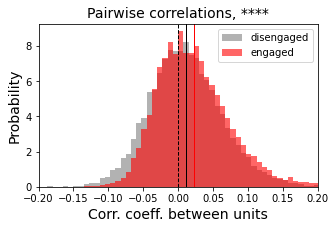

In [53]:
bins_nc = np.linspace(-0.3, 0.3, 81)
#bins_nc = np.linspace(-1, 1, 101)

#idx = 30
#corrs_shuf = corrs_shuf_all[idx]
#corrs_real = corrs_real_all[idx]

corrs1 = corrs_h_flat
corrs2 = corrs_l_flat

_, pval = stats.mannwhitneyu(corrs1, corrs2)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(corrs1, bins=bins_nc, density=True, alpha=0.6, color='grey', label='disengaged')
ax.hist(corrs2, bins=bins_nc, density=True, alpha=0.6, color='red', label='engaged')
ax.axvline(corrs2.mean(), color='red', lw=1)
ax.axvline(corrs1.mean(), color='black', lw=1)
#ax.axvline(np.median(corrs1), color='black', lw=1)
#ax.axvline(np.median(corrs2), color='red', lw=1)
ax.axvline(0, color='black', lw=1, ls='--')
ax.set_xlim(-0.2, 0.2)
#ax.set_xlim(-0.5, 0.5)
ax.legend()
ax.set_xlabel("Corr. coeff. between units", fontsize=14)
ax.set_ylabel("Probability", fontsize=14)
ax.set_title('Pairwise correlations, %s' % get_asterisks(pval), fontsize=14)

In [50]:
pval

7.366898603598349e-48